In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2.4.0
2.4.3


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13332589754958095508
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8855182400
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3239465206514849658
physical_device_desc: "device: 0, name: GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 400)

### Loading data

In [5]:
stock_list = ['Alior Bank', 'Allegro', 'Asseco', 'CCC', 'CD Projekt', 'Cyfrowy Polsat', 'Dino Polska', 'JSW', 'KGHM', 'Lotos', 'LPP', 'Orange Polska', 'PEKAO', 'PGE', 'PGNiG', 'PKN Orlen', 'PKO BP', 'PZU', 'Santander', 'Tauron']

directory = "WiG20 data/"
stock_data_list = []
stock_data = pd.DataFrame(columns=['Date', 'Open', 'Highest', 'Lowest', 'Close', 'Volume'])

for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    single_stock_data = pd.read_csv(file_path)
    single_stock_data = single_stock_data.rename(columns={'Data': 'Date', 'Otwarcie': 'Open', 'Najwyzszy': 'Highest', 'Najnizszy': 'Lowest', 'Zamkniecie': 'Close', 'Wolumen': 'Volume'})
    single_stock_data['Date'] = pd.to_datetime(single_stock_data.Date)
    stock_data_list.append(single_stock_data)
    single_stock_data['Stock'] = (filename[:3]).upper()
    stock_data = stock_data.append(single_stock_data, ignore_index=True)
    print('Loaded file: ' + filename)

Loaded file: acp_d.csv
Loaded file: ale_d.csv
Loaded file: alr_d.csv
Loaded file: ccc_d.csv
Loaded file: cdr_d.csv
Loaded file: cps_d.csv
Loaded file: dnp_d.csv
Loaded file: jsw_d.csv
Loaded file: kgh_d.csv
Loaded file: lpp_d.csv
Loaded file: lts_d.csv
Loaded file: opl_d.csv
Loaded file: peo_d.csv
Loaded file: pge_d.csv
Loaded file: pgn_d.csv
Loaded file: pkn_d.csv
Loaded file: pko_d.csv
Loaded file: pzu_d.csv
Loaded file: san_d.csv
Loaded file: tpe_d.csv


In [6]:
for i in range(len(stock_data_list)):
    stock_data_list[i] = stock_data_list[i].dropna()

In [7]:
def scale_data(data):
    list_of_features = []
    list_of_outputs = []
    for column in data.columns:
        list_of_features.append(data[column])
        if column in ['Open', 'Close', 'Highest', 'Lowest', 'Volume', 'Otwarcie', 'Najwyzszy', 'Najnizszy', 'Zamkniecie', 'Wolumen']:
            list_of_outputs.append(data[column])
        
    dataset = np.transpose(list_of_features)
    output_dataset = np.transpose(list_of_outputs)
    X_scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = X_scaler.fit_transform(dataset)
    Y_scaler = MinMaxScaler(feature_range=(0,1))
    Y_scaler.fit_transform(output_dataset)

    return scaled_data, X_scaler, Y_scaler

In [8]:
def prepare_input_and_output(data, number_of_sessions=60):
    # number_of_sessions - number of considered previous sessions as an input
    X = []
    Y = []
    for i in range(number_of_sessions, data.shape[0]):
        X.append(data[i-number_of_sessions:i, :])
        Y.append(data[i, :5])
    return X, Y

In [9]:
# Evaluation of the results is made on closing prices - it gives the most information about the usefullness of the model

def evaluate_results(X_valid, Y_valid, Y_scalers, predictions):

    predictions = Y_scalers[-1].inverse_transform(predictions)
    real_output = Y_scalers[-1].inverse_transform(Y_valid)

    predicted_data = pd.DataFrame(predictions, columns=['Open_predicted', 'Highest_predicted', 'Lowest_predicted', 'Close_predicted', 'Volume_predicted'])
    real_data = pd.DataFrame(real_output, columns=['Open_real', 'Highest_real', 'Lowest_real', 'Close_real', 'Volume_real'])
    predictions = pd.concat([real_data, predicted_data], axis=1)
    print(predictions[['Close_real', 'Close_predicted']].tail(20))

    predictions['Close_difference'] = abs(predictions['Close_real'] - predictions['Close_predicted'])
    predictions['Close_difference_percent'] = abs(predictions['Close_real'] - predictions['Close_predicted'])/predictions['Close_real'] * 100

    previous_close = predictions['Close_real'].shift(-1)
    Naive_forcast_MAPE = (abs(predictions['Close_real'] - previous_close)/predictions['Close_real'] * 100).mean()
    predictions_MAPE = predictions['Close_difference_percent'].mean()

    print('Naive forcast MAE: ' + str(round(abs(previous_close - predictions['Close_real']).mean(),2)))
    print('Predictions MAE: ' + str(round(predictions['Close_difference'].mean(),2)))
    print('Naive forcast MAPE: ' + str(round(Naive_forcast_MAPE,2)) + '%')
    print('Predictions MAPE: ' + str(round(predictions_MAPE,2)) + '%')
    
    return predictions

In [10]:
scaled_stocks = []
X_scalers = []
Y_scalers = []

for i in range(len(stock_data_list)):
    # Date is dropped as it isn't considered for learning
    scaled_stock, X_scaler, Y_scaler = scale_data(stock_data_list[i].drop(columns=['Stock', 'Date']))
  
    scaled_stocks.append(scaled_stock)
    X_scalers.append(X_scaler)
    Y_scalers.append(Y_scaler)

In [11]:
X_all = []
Y_all = []
scaled_X_list = []
scaled_Y_list = []

for stock in scaled_stocks:
    X, Y = prepare_input_and_output(stock, 60)
    scaled_X_list.append(np.array(X))
    scaled_Y_list.append(np.array(Y))
    X_all = X_all + X
    Y_all = Y_all + Y

X_all, Y_all = np.array(X_all), np.array(Y_all)
print('Shape of input matrix: ' + str(X_all.shape))
print('Shape of output matrix: ' + str(Y_all.shape))

Shape of input matrix: (76328, 60, 5)
Shape of output matrix: (76328, 5)


In [12]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=2666 - 60, shuffle=False)

### Defining and evaluating the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               68608     
_________________________________________________________________
dense (Dense)                (None, 300)               38700     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1505      
Total params: 108,813
Trainable params: 108,813
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
2304/2304 [==============================] - 16s 6ms/step - loss: 0.0027 - val_loss: 4.6654e-04
Epoch 2/15
2304/2304 [==============================] - 12s 5ms/step - loss: 4.7092e-04 - val_loss: 2.9981e-04
Epoch 3/15
2304/2304 [==============================] - 12s 5ms/step - loss: 4.6635e-04 - val_loss: 3.1418e-04
Epoch 4/15
2304/2304 [=============================

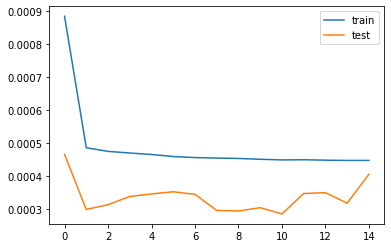

In [13]:
model = Sequential()
model.add(LSTM(128, input_shape=[X_train.shape[1], X_train.shape[2]]))#, return_sequences=True))
# model.add(LSTM(32))
model.add(Dense(300, activation='relu'))
model.add(Dense(Y_train.shape[1]))

model.summary()

model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=15, validation_data=(X_valid, Y_valid))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [14]:
predictions_basic = model.predict(X_valid)

predictions = evaluate_results(X_valid, Y_valid, Y_scalers, predictions_basic) # returns dataset

      Close_real  Close_predicted
2586       2.850         2.854717
2587       2.818         2.872195
2588       2.868         2.839271
2589       2.894         2.888365
2590       2.790         2.916900
2591       2.802         2.813334
2592       2.826         2.829466
2593       2.770         2.851137
2594       2.780         2.792878
2595       2.774         2.805803
2596       2.770         2.797113
2597       2.722         2.792633
2598       2.700         2.745658
2599       2.634         2.723040
2600       2.524         2.656296
2601       2.524         2.545850
2602       2.500         2.554807
2603       2.560         2.523592
2604       2.562         2.580277
2605       2.554         2.577069
Naive forcast MAE: 0.05
Predictions MAE: 0.06
Naive forcast MAPE: 1.59%
Predictions MAPE: 1.76%


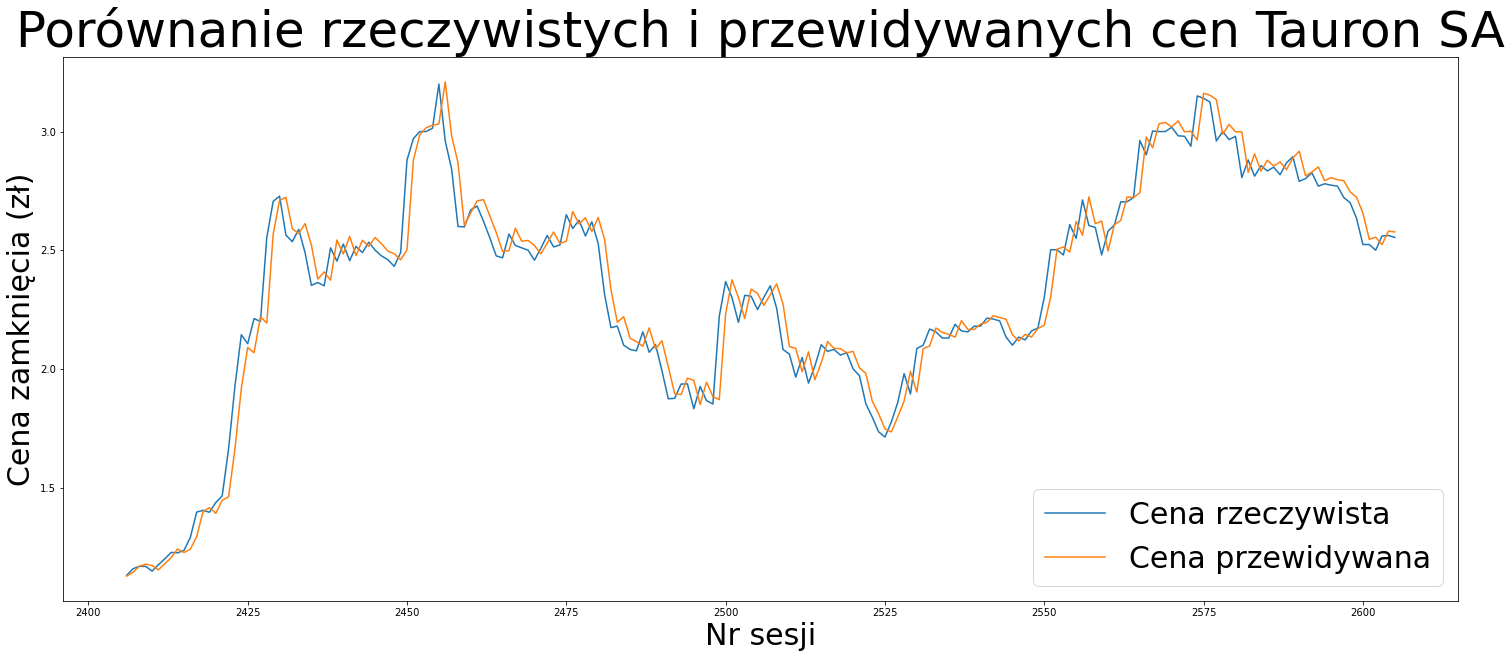

In [15]:
plt.figure(figsize=(25,10))
plt.title('Porównanie rzeczywistych i przewidywanych cen Tauron SA', fontsize=50)
plt.xlabel('Nr sesji', fontsize=30)
plt.ylabel('Cena zamknięcia (zł)', fontsize=30)
plt.plot(predictions['Close_real'].iloc[-200:])
plt.plot(predictions['Close_predicted'].iloc[-200:])
plt.legend(['Cena rzeczywista',  'Cena przewidywana'], loc='lower right', fontsize=30)
plt.show()

### Predictions on multiple days

In [16]:
stock_data

Date    Open  Highest  Lowest   Close   Volume Stock
0     1998-06-02  11.071   11.071  11.071  11.071   553241   ACP
1     1998-06-03  12.163   12.163  12.163  12.163   212085   ACP
2     1998-06-04  13.255   13.255  13.255  13.255   628114   ACP
3     1998-06-05  13.415   13.415  13.415  13.415   241411   ACP
4     1998-06-08  13.360   13.360  13.360  13.360   135799   ACP
...          ...     ...      ...     ...     ...      ...   ...
77524 2021-02-24   2.500    2.600   2.482   2.524  5424053   TPE
77525 2021-02-25   2.560    2.600   2.472   2.500  6324046   TPE
77526 2021-02-26   2.470    2.598   2.450   2.560  8567511   TPE
77527 2021-03-01   2.620    2.630   2.524   2.562  4569881   TPE
77528 2021-03-02   2.562    2.620   2.532   2.554  3619681   TPE

[77529 rows x 7 columns]

In [17]:
# passed values are input_vector sized (60, 5) (60 days * 5 features - Open, Highest, Lowest, Close, Volume) and n number of days we want to predict 
# returns vector (n, 5) with predictions
def predict_n_days_NN(input_vector, n):
    scaler = MinMaxScaler(feature_range=(0,1))
    X = scaler.fit_transform(input_vector)
    X = np.array(X).reshape(1, 60, 5)
    X_predicted = X
    predictions = []
    
    for day in range(n):
        prediction = model.predict(X_predicted)
        X_predicted = np.roll(X_predicted, -1, axis=1)
        X_predicted[:, -1, :] = prediction
        predictions.append(prediction)
    
#     X_predicted = scaler.inverse_transform(X_predicted.reshape(60, 5))
    predictions = np.array(predictions)
    predictions = scaler.inverse_transform(predictions.reshape(n, 5))
    
    return (predictions)

In [18]:
def predict_n_days_LR(input_vector, n):
    X = np.arange(0, input_vector.shape[0]).reshape(-1,1)
    lin_regr = LinearRegression().fit(X, input_vector)
    X_pred = np.arange(input_vector.shape[0] + 1, input_vector.shape[0] + n + 1).reshape(-1,1)
    prediction = lin_regr.predict(X_pred)
    return prediction
    

In [19]:
predictions_30_NN = predict_n_days_NN(stock_data.loc[stock_data['Stock'] == 'TPE', ['Open', 'Highest', 'Lowest', 'Close', 'Volume']][1000:1060], 30)

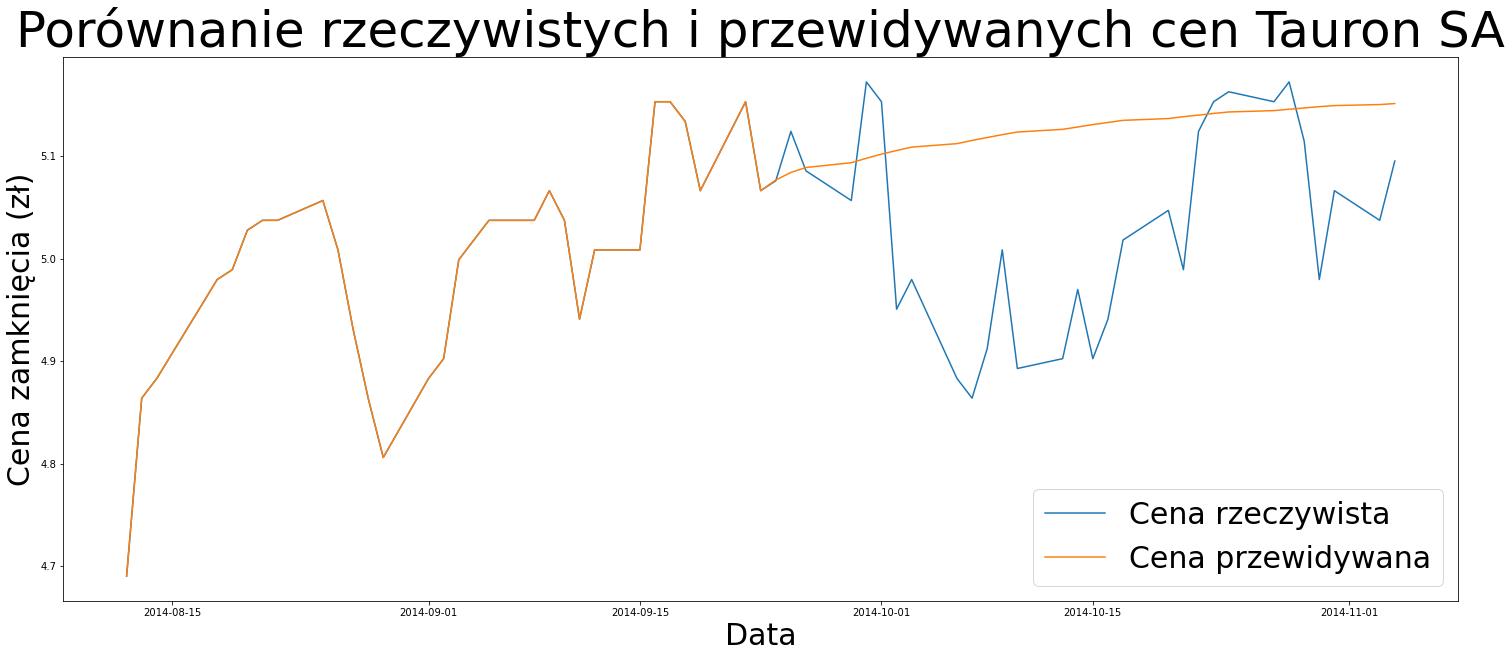

In [20]:
plt.figure(figsize=(25,10))
plt.title('Porównanie rzeczywistych i przewidywanych cen Tauron SA', fontsize=50)
plt.xlabel('Data', fontsize=30)
plt.ylabel('Cena zamknięcia (zł)', fontsize=30)
plt.plot(stock_data.loc[stock_data['Stock'] == 'TPE', 'Date'][1030:1090].values, stock_data.loc[stock_data['Stock'] == 'TPE', 'Close'][1030:1090].values)
plt.plot(stock_data.loc[stock_data['Stock'] == 'TPE', 'Date'][1030:1090].values, np.concatenate((stock_data.loc[stock_data['Stock'] == 'TPE', 'Close'][1030:1060].values, predictions_30_NN[:, 3])))
plt.legend(['Cena rzeczywista',  'Cena przewidywana'], loc='lower right', fontsize=30)
plt.show()

In [21]:
predictions_30_LR = predict_n_days_LR(stock_data.loc[stock_data['Stock'] == 'TPE', ['Open', 'Highest', 'Lowest', 'Close', 'Volume']][1000:1060], 30)

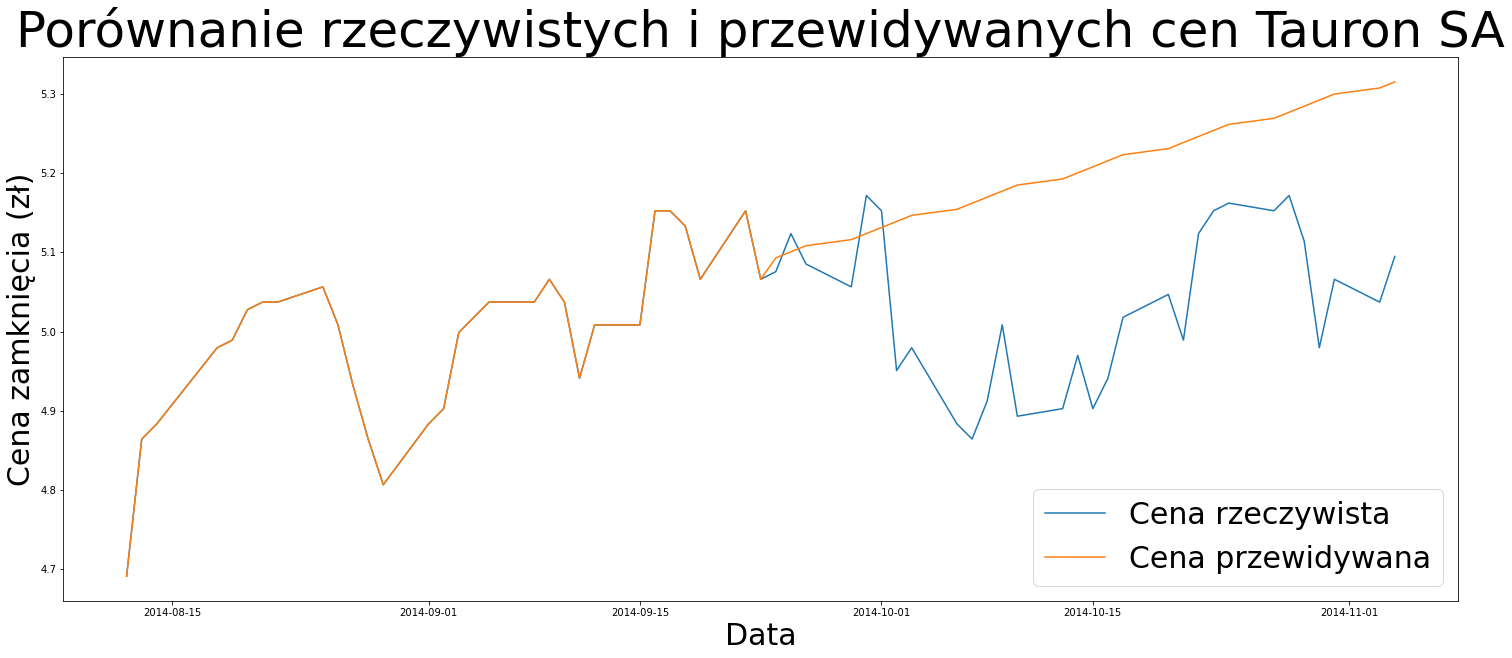

In [22]:
plt.figure(figsize=(25,10))
plt.title('Porównanie rzeczywistych i przewidywanych cen Tauron SA', fontsize=50)
plt.xlabel('Data', fontsize=30)
plt.ylabel('Cena zamknięcia (zł)', fontsize=30)
plt.plot(stock_data.loc[stock_data['Stock'] == 'TPE', 'Date'][1030:1090].values, stock_data.loc[stock_data['Stock'] == 'TPE', 'Close'][1030:1090].values)
plt.plot(stock_data.loc[stock_data['Stock'] == 'TPE', 'Date'][1030:1090].values, np.concatenate((stock_data.loc[stock_data['Stock'] == 'TPE', 'Close'][1030:1060].values, predictions_30_LR[:, 3])))
plt.legend(['Cena rzeczywista',  'Cena przewidywana'], loc='lower right', fontsize=30)
plt.show()

The curvature of the linear regression predictions is caused by the plot being based on dates. On weekends and some other days the stock sessions are closed. <br>
When the plot's X-axis is a evenly distributed date, the session based linear plot gets disturbed. Prove below.

In [23]:
plot_LR = pd.DataFrame(predictions_30_LR, columns=['Open', 'Highest', 'Lowest', 'Close', 'Volume'])

<AxesSubplot:>

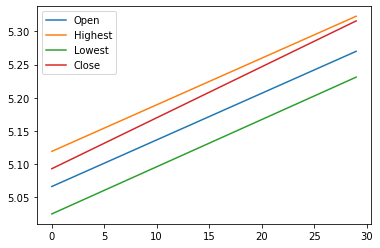

In [24]:
plot_LR[['Open', 'Highest', 'Lowest', 'Close']].plot() # the volume is droped as it's value is much greater than the prices.

Plot of the Neural Network predictions for comparision

In [25]:
plot_NN = pd.DataFrame(predictions_30_NN, columns=['Open', 'Highest', 'Lowest', 'Close', 'Volume'])

<AxesSubplot:>

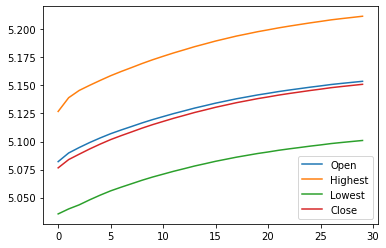

In [26]:
plot_NN[['Open', 'Highest', 'Lowest', 'Close']].plot() # the volume is droped as it's value is much greater than the prices.

## Evaluation of the predictions

In [29]:
stock = 'TPE'
stock_len = len(stock_data.loc[stock_data['Stock'] == stock])
start_idx = 60
days_to_predict = 30
end_idx = stock_len

predictions = pd.DataFrame(columns=['Date','Open_real','Highest_real','Lowest_real','Close_real','Volume_real','Prediction_days', 
                                    'Open_NN','Highest_NN','Lowest_NN','Close_NN','Volume_NN',
                                    'Open_LR','Highest_LR','Lowest_LR','Close_LR','Volume_LR'
                                   ])

for idx in range(start_idx, end_idx):
    if idx % 100 == 0:
        print(idx)
    predictions_NN = predict_n_days_NN(stock_data.loc[stock_data['Stock'] == stock, ['Open', 'Highest', 'Lowest', 'Close', 'Volume']][idx-60:idx], days_to_predict)
    predictions_LR = predict_n_days_LR(stock_data.loc[stock_data['Stock'] == stock, ['Open', 'Highest', 'Lowest', 'Close', 'Volume']][idx-60:idx], days_to_predict)
    
    for day in range(1, days_to_predict + 1):
        if idx + day >= stock_len-1:
            break
        date = stock_data.loc[stock_data['Stock'] == stock, ['Date']].iloc[idx + day-1].tolist()
        real_values = stock_data.loc[stock_data['Stock'] == stock, ['Open', 'Highest', 'Lowest', 'Close', 'Volume']].iloc[idx + day-1].tolist()
        
        row = date + real_values + [day] + predictions_NN[day-1].tolist() + predictions_LR[day-1].tolist()
        row = pd.Series(row, index=predictions.columns)
        predictions = predictions.append(row, ignore_index=True)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


In [30]:
predictions.head()

Date  Open_real  Highest_real  Lowest_real  Close_real Volume_real  \
0 2010-09-22     4.8825        4.8907       4.7693      4.8178    10344322   
1 2010-09-23     4.8017        4.8017       4.6966      4.7127     5512414   
2 2010-09-24     4.6884        4.9148       4.6884      4.9148     6156058   
3 2010-09-27     4.9309        4.9471       4.8907      4.9066     5389625   
4 2010-09-28     4.8987        4.9390       4.8178      4.9229     4281233   

  Prediction_days   Open_NN  Highest_NN  Lowest_NN  Close_NN   Volume_NN  \
0               1  4.916951    4.936582   4.866666  4.899159  10154086.0   
1               2  4.932602    4.947437   4.885636  4.914382  10696537.0   
2               3  4.945586    4.958093   4.900274  4.926738  11414758.0   
3               4  4.958371    4.969109   4.914330  4.938895  12083733.0   
4               5  4.971073    4.980417   4.927992  4.951003  12779660.0   

    Open_LR  Highest_LR  Lowest_LR  Close_LR      Volume_LR  
0  4.616951    4.685378   4.591939  4.655892  736616.080106  
1  4.628229    4.697622   4.603061  4.667856  445345.363601  
2  4.639507    4.709867   4.614183  4.679819  154074.647096  
3  4.650785    4.722111   4.625305  4.691782 -137196.069408  
4  4.662063    4.734355   4.636427  4.703745 -428466.785913

In [35]:
for column in predictions.columns:
    if column in ['Date', 'Prediction_days', 'Volume_real']:
        continue
    if column in ['Volume_NN', 'Volume_LR']:
        predictions[column] = predictions[column].astype('int32')
        continue
    predictions[column] = predictions[column].round(2)

predictions.head(31)

Date  Open_real  Highest_real  Lowest_real  Close_real Volume_real  \
0  2010-09-22       4.88          4.89         4.77        4.82    10344322   
1  2010-09-23       4.80          4.80         4.70        4.71     5512414   
2  2010-09-24       4.69          4.91         4.69        4.91     6156058   
3  2010-09-27       4.93          4.95         4.89        4.91     5389625   
4  2010-09-28       4.90          4.94         4.82        4.92     4281233   
5  2010-09-29       4.92          4.96         4.86        4.92     2044680   
6  2010-09-30       4.89          4.94         4.87        4.94     4487451   
7  2010-10-01       4.93          4.94         4.90        4.93     2947977   
8  2010-10-04       4.93          4.97         4.89        4.97     3938708   
9  2010-10-05       4.96          5.00         4.93        5.00     3082990   
10 2010-10-06       5.00          5.00         4.95        4.96     3621144   
11 2010-10-07       4.93          4.93         4.84        4.91     7151181   
12 2010-10-08       4.88          4.95         4.88        4.90     6910848   
13 2010-10-11       4.89          4.92         4.89        4.92     1026882   
14 2010-10-12       4.90          4.92         4.90        4.91     1499973   
15 2010-10-13       4.91          4.96         4.90        4.95     2593328   
16 2010-10-14       4.94          4.96         4.92        4.95     2361078   
17 2010-10-15       4.93          4.95         4.91        4.91     2357565   
18 2010-10-18       4.90          4.95         4.83        4.93     3848879   
19 2010-10-19       4.90          4.96         4.89        4.90     4386947   
20 2010-10-20       4.87          4.95         4.87        4.94     3730964   
21 2010-10-21       4.91          4.96         4.91        4.93     2225180   
22 2010-10-22       4.91          4.95         4.91        4.95     3106876   
23 2010-10-25       4.92          5.07         4.92        5.04    13610203   
24 2010-10-26       5.11          5.25         5.11        5.21    12836917   
25 2010-10-27       5.27          5.46         5.22        5.38    10987384   
26 2010-10-28       5.40          5.47         5.26        5.34     3927471   
27 2010-10-29       5.29          5.31         5.25        5.27     2733874   
28 2010-11-02       5.26          5.39         5.22        5.34     6187781   
29 2010-11-03       5.33          5.34         5.29        5.29     1480430   
30 2010-09-23       4.80          4.80         4.70        4.71     5512414   

   Prediction_days  Open_NN  Highest_NN  Lowest_NN  Close_NN  Volume_NN  \
0                1     4.92        4.94       4.87      4.90   10154086   
1                2     4.93        4.95       4.89      4.91   10696537   
2                3     4.95        4.96       4.90      4.93   11414758   
3                4     4.96        4.97       4.91      4.94   12083733   
4                5     4.97        4.98       4.93      4.95   12779660   
5                6     4.98        4.99       4.94      4.96   13518108   
6                7     5.00        5.00       4.95      4.98   14296480   
7                8     5.01        5.02       4.97      4.99   15112934   
8                9     5.02        5.03       4.98      5.00   15960515   
9               10     5.03        5.04       4.99      5.01   16832212   
10              11     5.05        5.05       5.00      5.02   17750590   
11              12     5.06        5.06       5.02      5.03   18678408   
12              13     5.07        5.07       5.03      5.05   19647326   
13              14     5.08        5.08       5.04      5.06   20626694   
14              15     5.09        5.09       5.05      5.07   21673602   
15              16     5.10        5.10       5.06      5.08   22775880   
16              17     5.11        5.11       5.07      5.09   23908356   
17              18     5.12        5.12       5.07      5.09   25043784   
18              19     5.13        5.13       5.08     

In [36]:
predictions_evaluation = pd.DataFrame(columns = ['Prediction_days', 'NN_open_MAPE', 'NN_highest_MAPE', 'NN_lowest_MAPE', 'NN_close_MAPE', 'NN_volume_MAPE',
                                                 'LR_open_MAPE', 'LR_highest_MAPE', 'LR_lowest_MAPE', 'LR_close_MAPE', 'LR_volume_MAPE',
                                                 'Naive_open_MAPE', 'Naive_highest_MAPE', 'Naive_lowest_MAPE', 'Naive_close_MAPE', 'Naive_volume_MAPE'])

for day in range(1, days_to_predict + 1):
    NN_open_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Open_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Open_NN'])/predictions.loc[predictions['Prediction_days'] == day, 'Open_real']).abs().mean() * 100
    NN_highest_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Highest_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Highest_NN'])/predictions.loc[predictions['Prediction_days'] == day, 'Highest_real']).abs().mean() * 100
    NN_lowest_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Lowest_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Lowest_NN'])/predictions.loc[predictions['Prediction_days'] == day, 'Lowest_real']).abs().mean() * 100
    NN_close_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Close_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Close_NN'])/predictions.loc[predictions['Prediction_days'] == day, 'Close_real']).abs().mean() * 100
    NN_volume_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Volume_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Volume_NN'])/predictions.loc[predictions['Prediction_days'] == day, 'Volume_real']).abs().mean() * 100
    
    LR_open_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Open_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Open_LR'])/predictions.loc[predictions['Prediction_days'] == day, 'Open_real']).abs().mean() * 100
    LR_highest_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Highest_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Highest_LR'])/predictions.loc[predictions['Prediction_days'] == day, 'Highest_real']).abs().mean() * 100
    LR_lowest_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Lowest_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Lowest_LR'])/predictions.loc[predictions['Prediction_days'] == day, 'Lowest_real']).abs().mean() * 100
    LR_close_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Close_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Close_LR'])/predictions.loc[predictions['Prediction_days'] == day, 'Close_real']).abs().mean() * 100
    LR_volume_MAPE = ((predictions.loc[predictions['Prediction_days'] == day, 'Volume_real'] - predictions.loc[predictions['Prediction_days'] == day, 'Volume_LR'])/predictions.loc[predictions['Prediction_days'] == day, 'Volume_real']).abs().mean() * 100    
    
    Naive_open_MAPE = (abs(predictions.loc[predictions['Prediction_days'] == day, 'Open_real'].diff(periods=day)) / predictions.loc[predictions['Prediction_days'] == day, 'Open_real']).mean() * 100
    Naive_highest_MAPE = (abs(predictions.loc[predictions['Prediction_days'] == day, 'Highest_real'].diff(periods=day)) / predictions.loc[predictions['Prediction_days'] == day, 'Highest_real']).mean() * 100
    Naive_lowest_MAPE = (abs(predictions.loc[predictions['Prediction_days'] == day, 'Lowest_real'].diff(periods=day)) / predictions.loc[predictions['Prediction_days'] == day, 'Lowest_real']).mean() * 100
    Naive_close_MAPE = (abs(predictions.loc[predictions['Prediction_days'] == day, 'Close_real'].diff(periods=day)) / predictions.loc[predictions['Prediction_days'] == day, 'Close_real']).mean() * 100
    Naive_volume_MAPE = (abs(predictions.loc[predictions['Prediction_days'] == day, 'Volume_real'].diff(periods=day)) / predictions.loc[predictions['Prediction_days'] == day, 'Volume_real']).mean() * 100
    
    row = [day, NN_open_MAPE, NN_highest_MAPE, NN_lowest_MAPE, NN_close_MAPE, NN_volume_MAPE, 
           LR_open_MAPE, LR_highest_MAPE, LR_lowest_MAPE, LR_close_MAPE, LR_volume_MAPE, 
           Naive_open_MAPE, Naive_highest_MAPE, Naive_lowest_MAPE, Naive_close_MAPE, Naive_volume_MAPE]
    row = pd.Series(row, index=predictions_evaluation.columns)
    predictions_evaluation = predictions_evaluation.append(row, ignore_index=True)
    
predictions_evaluation['Prediction_days'] = predictions_evaluation['Prediction_days'].astype('int32')

In [37]:
predictions_evaluation

Prediction_days  NN_open_MAPE  NN_highest_MAPE  NN_lowest_MAPE  \
0                 1      0.835071         1.154759        1.151448   
1                 2      1.842684         2.006362        2.021418   
2                 3      2.501395         2.596848        2.640288   
3                 4      3.024633         3.089987        3.152572   
4                 5      3.482989         3.524230        3.589365   
5                 6      3.919667         3.952942        4.029567   
6                 7      4.308360         4.321922        4.402896   
7                 8      4.651033         4.663723        4.781688   
8                 9      4.989901         4.983552        5.113035   
9                10      5.308620         5.289983        5.442563   
10               11      5.626070         5.593994        5.763962   
11               12      5.914457         5.868925        6.077532   
12               13      6.205649         6.163624        6.364610   
13               14      6.486695         6.446350        6.652120   
14               15      6.757714         6.703951        6.917617   
15               16      7.013016         6.968064        7.175073   
16               17      7.269742         7.212333        7.429804   
17               18      7.510673         7.444318        7.692145   
18               19      7.753017         7.667771        7.935204   
19               20      7.969229         7.900741        8.205794   
20               21      8.196489         8.117683        8.410990   
21               22      8.423769         8.332278        8.635160   
22               23      8.642367         8.568338        8.864529   
23               24      8.875818         8.804568        9.088726   
24               25      9.100014         9.037077        9.334382   
25               26      9.343973         9.273267        9.565295   
26               27      9.563418         9.505723        9.800305   
27               28      9.817509         9.746707       10.047257   
28               29     10.051866         9.995723       10.304555   
29               30     10.306915        10.237976       10.538488   

    NN_close_MAPE  NN_volume_MAPE  LR_open_MAPE  LR_highest_MAPE  \
0        1.643433       52.700048      4.867178         4.745179   
1        2.392865       58.869162      5.221722         5.099711   
2        2.971319       61.576428      5.572413         5.447394   
3        3.449503       63.995664      5.905779         5.783446   
4        3.893537       66.618973      6.237024         6.108100   
5        4.303142       69.819133      6.567871         6.440078   
6        4.676588       72.103615      6.892637         6.762758   
7        5.023845       74.308942      7.211238         7.089962   
8        5.328022       76.658255      7.532505         7.403726   
9        5.648832       78.915767      7.854685         7.722819   
10       5.936927       81.350579      8.179032         8.036030   
11       6.232605       83.516031      8.503144         8.352450   
12       6.513937       85.758661      8.832248         8.676247   
13       6.805603       87.922210      9.156205         8.989903   
14       7.070055       89.424297      9.478199         9.300087   
15       7.319876       91.705789      9.796241         9.612179   
16       7.550102       94.021574     10.114981         9.926742   
17       7.792333       95.964382     10.433641        10.237676   
18       8.022313       97.907368     10.757957        10.560207   
19       8.253754       99.941174     11.078533        10.878708   
20       8.462084      102.389722     11.401078        11.197798   
21       8.678454      104.783304     11.723067        11.516413   
22       8.913102      106.613111     12.045126        11.834235   
23       9.141906      108.550831     12.365156        12.147924   
24       9.365225      110.319223     12.690742        12.480547   
25       9.592239      112.152606     13.018794        12.799053 

In [38]:
predictions_evaluation.to_csv('predictions_evaluation.csv')